In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import os
import pickle as pkl
from collections.abc import MutableMapping
import time
from typing import Any, Callable, Iterable, Mapping, Optional, Union
import json

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import tqdm
from IPython.display import HTML

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import jax
from jax import vmap, lax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import flax
from flax import linen as nn
import optax
from frozendict import frozendict

import jraph
from jraph._src import graph as gn_graph
from jraph._src import utils

print(f'Jax: CPUs={jax.local_device_count("cpu")} - GPUs={jax.local_device_count("gpu")}')

Jax: CPUs=1 - GPUs=1


In [3]:
from hgnn.noisify import add_noise_and_truncate
from hgnn.model import *
from hgnn.hamiltonian import *
from hgnn.training import *
from hgnn.simulating import *

In [4]:
# prefix = 'pendulum-n2'
prefix = 'pendulum-n3'

Zs_train = jnp.load(f'./data/{prefix}/Zs_train.npy')
Zs_dot_train = jnp.load(f'./data/{prefix}/Zs_dot_train.npy')
Zs_test = jnp.load(f'./data/{prefix}/Zs_test.npy')
Zs_dot_test = jnp.load(f'./data/{prefix}/Zs_dot_test.npy')

Zs_train, Zs_dot_train = add_noise_and_truncate(Zs_train, Zs_dot_train, scale=0.01, decimals=2)
# Zs_test, Zs_dot_test = add_noise_and_truncate(Zs_test, Zs_dot_test, scale=0.01, decimals=2)

N2, dim = Zs_train.shape[-2:]
N = N2 // 2
species = jnp.zeros(N, dtype=int)
masses = jnp.ones(N)

Zs = Zs_train.reshape(-1, N2, dim)
Zs_dot = Zs_dot_train.reshape(-1, N2, dim)

Zst = Zs_test.reshape(-1, N2, dim)
Zst_dot = Zs_dot_test.reshape(-1, N2, dim)

print('N2:', N2)
print('dim:', dim)
print('Zs.shape:', Zs.shape)
print('Zs_dot.shape:', Zs_dot.shape)
print('Zst.shape:', Zst.shape)
print('Zst_dot.shape:', Zst_dot.shape)
print('Zs_test.shape:', Zs_test.shape)
print()

with open(f'./data/{prefix}/param.json', 'r') as f:
    d = json.load(f)
    stride = d['stride']
    dt = d['dt']
    lr = d['lr']
    batch_size = d['batch_size']
    epochs = d['epochs']
    
print('stride:', stride)
print('dt:', dt)
print('lr:', lr)
print('batch_size:', batch_size)
print('epochs:', epochs)

N2: 6
dim: 2
Zs.shape: (7500, 6, 2)
Zs_dot.shape: (7500, 6, 2)
Zst.shape: (2500, 6, 2)
Zst_dot.shape: (2500, 6, 2)
Zs_test.shape: (25, 100, 6, 2)

stride: 1000
dt: 1e-05
lr: 0.01
batch_size: 100
epochs: 2000


In [5]:
def pendulum_connections(P):
    return (jnp.array([i for i in range(P-1)] + [i for i in range(1, P)], dtype=int),
            jnp.array([i for i in range(1, P)] + [i for i in range(P-1)], dtype=int))

def edge_order(P):
    N = (P-1)
    return jnp.array(jnp.hstack([jnp.array(range(N, 2*N)), jnp.array(range(N))]), dtype=int)

senders, receivers = pendulum_connections(N)
eorder = edge_order(N)

In [6]:
key = jax.random.PRNGKey(42)

Ef = 1  # eij dim
Oh = 1

Eei = 5
Nei = 5

hidden = 5
nhidden = 2

In [7]:
params = generate_HGNN_params(Oh, Nei, Ef, Eei, dim, hidden, nhidden, key)

In [8]:
R, V = jnp.split(Zs[0], 2, axis=0)

apply_fn = energy_fn(senders=senders, receivers=receivers, species=species, R=R, V=V, eorder=eorder)
Hmodel = generate_Hmodel(apply_fn)


def phi(x):
    X = jnp.vstack([x[:1, :]*0, x])
    return jnp.square(X[:-1, :] - X[1:, :]).sum(axis=1) - 1.0

constraints = get_constraints(N, dim, phi)

zdot_model, lamda_force_model = get_zdot_lambda(
    N, dim, hamiltonian=Hmodel, drag=None, 
    constraints=constraints, 
    external_force=None)


v_zdot_model = vmap(zdot_model, in_axes=(0, 0, None))

Training ...


/tmp/ipykernel_953540/2977881841.py:31: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tqdm.tnrange(epochs):


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 100/2000 Loss (MSE):  train=0.39818787574768066, test=0.11279121041297913
Epoch: 200/2000 Loss (MSE):  train=0.31179434061050415, test=0.015320032835006714
Epoch: 300/2000 Loss (MSE):  train=0.27431797981262207, test=0.003930279053747654
Epoch: 400/2000 Loss (MSE):  train=0.27258291840553284, test=0.006972229108214378
Epoch: 500/2000 Loss (MSE):  train=0.2905471622943878, test=0.006963543593883514
Epoch: 600/2000 Loss (MSE):  train=0.2794424593448639, test=0.020692184567451477
Epoch: 700/2000 Loss (MSE):  train=0.27867013216018677, test=0.022044004872441292
Epoch: 800/2000 Loss (MSE):  train=0.2749366760253906, test=0.020449748262763023
Epoch: 900/2000 Loss (MSE):  train=0.2755354046821594, test=0.01886010728776455
Epoch: 1000/2000 Loss (MSE):  train=0.28850075602531433, test=0.03319595009088516
Epoch: 1100/2000 Loss (MSE):  train=0.2770644426345825, test=0.020944388583302498
Epoch: 1200/2000 Loss (MSE):  train=0.2771657705307007, test=0.02103458158671856
Epoch: 1300/2000 Loss (

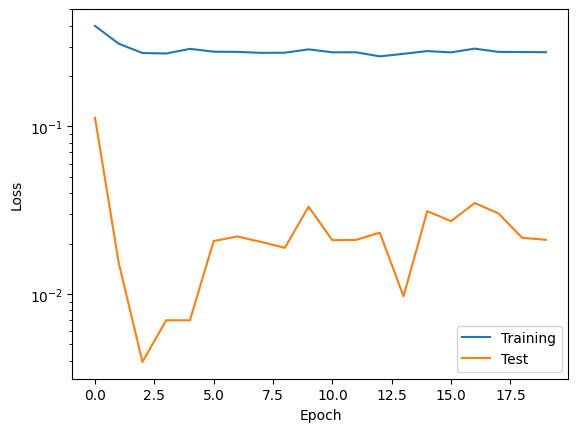

In [9]:
loss_fn = generate_loss_fn(v_zdot_model=v_zdot_model)
gloss = generate_gloss(loss_fn=loss_fn)

opt_init, opt_update_, get_params = optimizers.adam(lr)

opt_update = generate_opt_update_wrapper(opt_update_=opt_update_)

step = generate_update_fn(gloss=gloss, opt_update=opt_update, get_params=get_params)

Rs, Vs = jnp.split(Zs, 2, axis=1)
Rst, Vst = jnp.split(Zst, 2, axis=1)

bRs, bVs, bZs_dot = batching(Rs, Vs, Zs_dot,
                            size=min(len(Rs), batch_size))

print(f"Training ...")

# opt_state = optimiser.init(params)
opt_state = opt_init(params)

epoch = 0
optimizer_step = -1
larray = []
ltarray = []

start = time.time()
train_time_arr = []

last_loss = 1000

for epoch in tqdm.tnrange(epochs):
    l = 0.0
    for data in zip(bRs, bVs, bZs_dot):
        optimizer_step += 1
        opt_state, params, l_ = step(optimizer_step, (opt_state, params, 0), *data)
        l += l_
    l = l/len(bRs)
    if (epoch + 1) % (epochs // 20) == 0:
        # opt_state, params, l = step(
        #     optimizer_step, (opt_state, params, 0), Rs, Vs, Zs_dot)
        larray += [l]
        ltarray += [loss_fn(params, Rst, Vst, Zst_dot)]
        print(f"Epoch: {epoch + 1}/{epochs} Loss (MSE):  train={larray[-1]}, test={ltarray[-1]}")

    now = time.time()
    train_time_arr.append((now - start))
    
params = get_params(opt_state)

fig, axs = plt.subplots(1, 1)
plt.semilogy(larray, label="Training")
plt.semilogy(ltarray, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [14]:
maxtraj = Zs_test.shape[0]
runs = Zs_test.shape[1]

sim_model = get_forward_sim(params=params, zdot_model=zdot_model, runs=runs, stride=stride, dt=dt)

trajectories = []

for ind in tqdm.tnrange(maxtraj):

    z_actual_out = Zs_test[ind, :runs]
    x_act_out, p_act_out = jnp.split(z_actual_out, 2, axis=1)

    R = Zs_test[ind, 0, :N]
    V = Zs_test[ind, 0, N:]
    z_pred_out = sim_model(R, V)
    x_pred_out, p_pred_out = jnp.split(z_pred_out, 2, axis=1)

    trajectories.append({
        'pred_pos': x_pred_out,
        'pred_vel': p_pred_out,
        'actual_pos': x_act_out,
        'actual_vel': p_act_out,
    })

/tmp/ipykernel_953540/287510181.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for ind in tqdm.tnrange(maxtraj):


  0%|          | 0/25 [00:00<?, ?it/s]

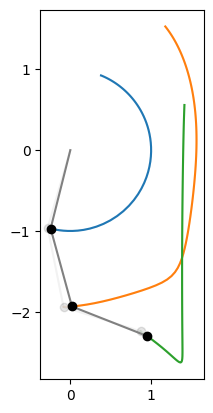

In [15]:
idx = 1

r = trajectories[idx]['actual_pos']

for i in range(r.shape[1]):
    plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=0.1)
    
plt.plot([0] + list(r[-1,:,0]), [0] + list(r[-1,:,1]), '-', color='gray', alpha=0.1)
plt.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=0.1)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()

r = trajectories[idx]['pred_pos']

for i in range(r.shape[1]):
    plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}')
    
plt.plot([0] + list(r[-1,:,0]), [0] + list(r[-1,:,1]), '-', color='gray', alpha=1.)
plt.plot(r[-1,:,0], r[-1,:,1], 'o', color='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [17]:
idx = 1

fig, ax = plt.subplots()

r = trajectories[idx]['actual_pos']
traj_actual = [ax.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=0.1)[0] for i in range(r.shape[1])]  
rods_actual, = ax.plot([0] + list(r[-1,:,0]), [0] + list(r[-1,:,1]), '-', color='gray', alpha=0.1)
ball_actual, = ax.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=0.1)

r = trajectories[idx]['pred_pos']
traj_pred = [ax.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=1.)[0] for i in range(r.shape[1])]  
rods_pred, = ax.plot([0] + list(r[-1,:,0]), [0] + list(r[-1,:,1]), '-', color='gray', alpha=1.)
ball_pred, = ax.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=1.)

def gather():
    return traj_actual + [rods_actual, ball_actual] + traj_pred + [rods_pred, ball_pred]

def init():
    s = 1.1 * r.shape[1]
    ax.set_xlim(-s, s)
    ax.set_ylim(-s, s)
    ax.set_aspect('equal', adjustable='box')
    return gather()

def update(frame):
    
    r = trajectories[idx]['actual_pos']
    for i in range(r.shape[1]):
        traj_actual[i].set_data(r[:frame,i,0], r[:frame,i,1])
    rods_actual.set_data([0] + list(r[frame,:,0]), [0] + list(r[frame,:,1]))
    ball_actual.set_data(r[frame,:,0], r[frame,:,1])

    r = trajectories[idx]['pred_pos']
    for i in range(r.shape[1]):
        traj_pred[i].set_data(r[:frame,i,0], r[:frame,i,1])
    rods_pred.set_data([0] + list(r[frame,:,0]), [0] + list(r[frame,:,1]))
    ball_pred.set_data(r[frame,:,0], r[frame,:,1])
    
    return gather()

ani = FuncAnimation(fig, update, frames=tqdm.tnrange(runs), init_func=init, blit=True, interval=20)
plt.close(fig)
HTML(ani.to_jshtml())

/tmp/ipykernel_953540/260104629.py:41: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  ani = FuncAnimation(fig, update, frames=tqdm.tnrange(runs), init_func=init, blit=True, interval=20)


  0%|          | 0/100 [00:00<?, ?it/s]